In [26]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import datetime

In [27]:
def download_data(ticker, start_date, end_date):
    try:
        df = yf.download(ticker, start=start_date, end=end_date)
        return df['Close'].rename(ticker)
    except Exception as e:
        print(f"Error downloading data for {ticker}: {e}")
        return pd.Series(name=ticker)

In [28]:
end_date = datetime.datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.datetime.now() - datetime.timedelta(days=20*365)).strftime('%Y-%m-%d')

In [29]:
tickers = ['FRSH', 'NEM', 'XOM', 'INR=X']

dataframes = [download_data(ticker, start_date, end_date) for ticker in tickers]
merged_data = pd.concat(dataframes, axis=1).dropna()
merged_data.columns = ['FRESHWORKS', 'GOLD', 'PETROL', 'CURRENCY']

merged_data.to_csv('merged_data.csv')

data = pd.read_csv('merged_data.csv')

[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [30]:
data['Date'] = pd.to_datetime(data['Date'])

data.set_index('Date', inplace=True)

data.dropna(inplace=True)

c:\Users\shais\.conda\envs\tf\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0671 - val_loss: 0.0013
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0108 - val_loss: 0.0010
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0035 - val_loss: 0.0017
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 12/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017 - val_l

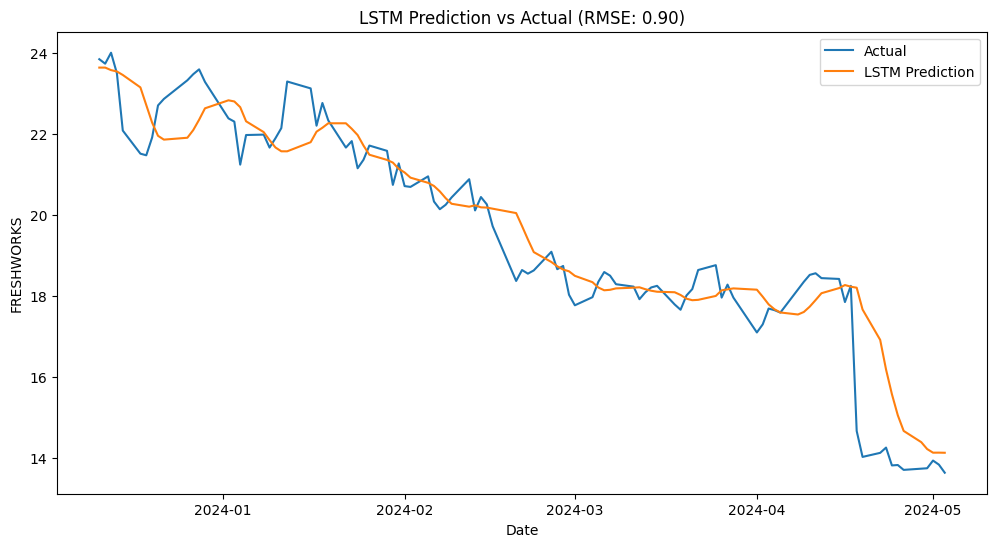

Root Mean Squared Error (RMSE): 0.90
Error Percentage: 4.63%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Forecasted stock prices for the upcoming 7 days:
2024-05-18: 23.632938385009766
2024-05-19: 23.633346557617188
2024-05-20: 23.570865631103516
2024-05-21: 23.5371036529541
2024-05-22: 23.45134735107422
2024-05-23: 23.144847869873047


In [31]:
target_variable = 'FRESHWORKS'

y = data[target_variable].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler.fit_transform(y)

def create_sequences(data, seq_length):
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

sequence_length = 10

X_seq, y_seq = create_sequences(y_scaled, sequence_length)

train_size, val_size = int(len(X_seq) * 0.7), int(len(X_seq) * 0.15)
test_size = len(X_seq) - train_size - val_size
X_train, y_train = X_seq[:train_size], y_seq[:train_size]
X_val, y_val = X_seq[train_size:train_size+val_size], y_seq[train_size:train_size+val_size]
X_test, y_test = X_seq[train_size+val_size:], y_seq[train_size+val_size:]

model_lstm = Sequential()
model_lstm.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=1)

y_pred_lstm = model_lstm.predict(X_test)

y_pred_lstm_inv = scaler.inverse_transform(y_pred_lstm)
y_test_inv = scaler.inverse_transform(y_test)

rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, y_pred_lstm_inv))

test_dates = data.index[train_size+val_size: train_size+val_size+len(y_test_inv)]
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_inv, label='Actual')
plt.plot(test_dates, y_pred_lstm_inv, label='LSTM Prediction')
plt.title(f'LSTM Prediction vs Actual (RMSE: {rmse_lstm:.2f})')
plt.xlabel('Date')
plt.ylabel(target_variable)
plt.legend()
plt.show()

error_percentage = (rmse_lstm / np.mean(y_test_inv)) * 100
print(f'Root Mean Squared Error (RMSE): {rmse_lstm:.2f}')
print(f'Error Percentage: {error_percentage:.2f}%')

forecasted_values_scaled = []
for _ in range(7):
    X_new = np.array([X_test[_]])
    forecasted_value_scaled = model_lstm.predict(X_new)[0][0]
    forecasted_values_scaled.append(forecasted_value_scaled)
    X_test = np.concatenate((X_test, X_new), axis=0)

forecasted_values = scaler.inverse_transform(np.array(forecasted_values_scaled).reshape(-1, 1))
forecasted_dates = pd.date_range(data.index[-1], periods=7, freq='D')[1:]

print("Forecasted stock prices for the upcoming 7 days:")
for date, price in zip(forecasted_dates, forecasted_values):
    print(f"{date.strftime('%Y-%m-%d')}: {price[0]}")